
<div><h1><b> Commit Topic Modeling</b> </h1>
</div>

# Preparation

Install external packages

In [ ]:
# !pip install PyGithub -q
!pip install tomotopy -q
!pip install pyldavis -q
!pip install wordcloud -q
!pip install octis -q
# !pip install -U sentence-transformers -q

     |████████████████████████████████| 16.3 MB 29.2 MB/s 
     |████████████████████████████████| 1.7 MB 25.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 129 kB 30.8 MB/s 
     |████████████████████████████████| 22.3 MB 18.6 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 100 kB 11.8 MB/s 
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
     |████████████████████████████████| 170 kB 61.4 MB/s 
     |████████████████████████████████| 4.2 MB 54.4 MB/s 
     |████████████████████████████████| 1.2 MB 53.4 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 63.6 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

Import required packages

In [ ]:
import pandas as pd
import sklearn 
import numpy as np
import tomotopy as tp
print(tp.isa) # prints 'avx2', 'avx', 'sse2' or 'none' # processing instruction set
import json
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm
from collections import Counter
import pyLDAvis
from wordcloud import WordCloud
import gensim
import os.path
# from sentence_transformers import SentenceTransformer
import urllib
import pickle
from octis.models.LDA import LDA
#from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

avx2
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/TOM"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
issues_path = os.path.join(PATH, "issues", "issues.csv")
bugissues_path = os.path.join(PATH, "issues", "bugissues.csv")

fixingcommits = pd.read_csv(os.path.join(PATH, "commits", "fixingcommits.csv"))



bugissues = pd.read_csv(bugissues_path)
issues = pd.read_csv(issues_path)

Read Pulls

In [ ]:
pulls_path = os.path.join(PATH, "pulls", "pulls.csv")

pulls = pd.read_csv(pulls_path)
# commits_text = pulls['commit'].apply(json.loads).apply(pd.Series)['message']


pulls.head()
# issues.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,url,id,node_id,html_url,diff_url,patch_url,issue_url,number,state,locked,...,review_comments_url,review_comment_url,comments_url,statuses_url,head,base,_links,author_association,auto_merge,active_lock_reason
0,"""https://api.github.com/repos/cryptokylin/Cryp...",236857041,"""MDExOlB1bGxSZXF1ZXN0MjM2ODU3MDQx""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",35,"""closed""",False,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""pete001:patch-1"", ""ref"": ""patch-1"",...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
1,"""https://api.github.com/repos/cryptokylin/Cryp...",230730576,"""MDExOlB1bGxSZXF1ZXN0MjMwNzMwNTc2""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",27,"""closed""",False,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""zsq978663747:master"", ""ref"": ""maste...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
2,"""https://api.github.com/repos/cryptokylin/Cryp...",228156890,"""MDExOlB1bGxSZXF1ZXN0MjI4MTU2ODkw""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",26,"""closed""",False,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""newbdez33:patch-1"", ""ref"": ""patch-1...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
3,"""https://api.github.com/repos/cryptokylin/Cryp...",227266071,"""MDExOlB1bGxSZXF1ZXN0MjI3MjY2MDcx""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",25,"""closed""",False,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""meet-one:master"", ""ref"": ""master"", ...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
4,"""https://api.github.com/repos/cryptokylin/Cryp...",222061939,"""MDExOlB1bGxSZXF1ZXN0MjIyMDYxOTM5""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",23,"""closed""",False,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""zsq978663747:master"", ""ref"": ""maste...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN


In [ ]:
pulls[['title', 'body']]

,title,body
0,"""I tested all the nodes, these are the remaini...",""""""
1,"""add how to use back-up to readme """,""""""
2,"""Add JEDA api endpoint""",""""""
3,"""Update README.md""",""""""
4,"""\u66f4\u65b0faucet\u7684\u63a5\u53e3""","""\u6700\u8fd1\u53d1\u73b0faucet\u7684\u63a5\u5..."
...,...,...
18732,"""Bump url-parse from 1.4.7 to 1.5.7""","""Bumps [url-parse](https://github.com/unshifti..."
18733,"""Bump follow-redirects from 1.13.0 to 1.14.8""","""Bumps [follow-redirects](https://github.com/f..."
18734,"""Bump handlebars from 4.7.6 to 4.7.7""","""Bumps [handlebars](https://github.com/wycats/..."
18735,"""Bump follow-redirects from 1.13.0 to 1.14.7""","""Bumps [follow-redirects](https://github.com/f..."


Read Commits

In [ ]:
commits_path = os.path.join(PATH, "commits", "pullcommits.csv")

commits = pd.read_csv(commits_path)
commits_text = commits['commit'].apply(json.loads).apply(pd.Series)['message']


commits.head()

,sha,node_id,commit,url,html_url,comments_url,author,committer,parents,pull_url
0,"""8373525cee7321b6cea537e12831d4e4ae70d3b8""","""MDY6Q29tbWl0MTYwODIyNzMwOjgzNzM1MjVjZWU3MzIxY...","{""author"": {""name"": ""Pete Cheyne"", ""email"": ""p...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...","{""login"": ""pete001"", ""id"": 410428, ""node_id"": ...","{""login"": ""web-flow"", ""id"": 19864447, ""node_id...","[{""sha"": ""067bc476f0eaf143c6e6780dda39adefa6e0...",https://api.github.com/repos/cryptokylin/Crypt...
1,"""e37d498a503b7e0b0df5eac8a591a398baf879b5""","""MDY6Q29tbWl0MTYwODIyNzMwOmUzN2Q0OThhNTAzYjdlM...","{""author"": {""name"": ""Pete Cheyne"", ""email"": ""p...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...","{""login"": ""pete001"", ""id"": 410428, ""node_id"": ...","{""login"": ""web-flow"", ""id"": 19864447, ""node_id...","[{""sha"": ""8373525cee7321b6cea537e12831d4e4ae70...",https://api.github.com/repos/cryptokylin/Crypt...
2,"""1aa091a7d81740a8eb33b41ccaf7bccd5303a307""","""MDY6Q29tbWl0MTYwODIyNzMwOjFhYTA5MWE3ZDgxNzQwY...","{""author"": {""name"": ""Pete Cheyne"", ""email"": ""p...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...","{""login"": ""pete001"", ""id"": 410428, ""node_id"": ...","{""login"": ""web-flow"", ""id"": 19864447, ""node_id...","[{""sha"": ""e37d498a503b7e0b0df5eac8a591a398baf8...",https://api.github.com/repos/cryptokylin/Crypt...
3,"""ca35f0a37893f0035191e93af62781f90b37ee7d""","""MDY6Q29tbWl0MTQ2Mzg3MDI5OmNhMzVmMGEzNzg5M2YwM...","{""author"": {""name"": ""zhangshiqi"", ""email"": ""32...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...","{""login"": ""zsq978663747"", ""id"": 32862838, ""nod...","{""login"": ""web-flow"", ""id"": 19864447, ""node_id...","[{""sha"": ""3f93b88232c6380c79040115c8957f6d30e1...",https://api.github.com/repos/cryptokylin/Crypt...
4,"""c133f633a6a8cafbf1e124ca6aebf249f3691fc9""","""MDY6Q29tbWl0MTQ2Mzg3MDI5OmMxMzNmNjMzYTZhOGNhZ...","{""author"": {""name"": ""zhangshiqi"", ""email"": ""32...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...","{""login"": ""zsq978663747"", ""id"": 32862838, ""nod...","{""login"": ""web-flow"", ""id"": 19864447, ""node_id...","[{""sha"": ""ca35f0a37893f0035191e93af62781f90b37...",https://api.github.com/repos/cryptokylin/Crypt...


In [ ]:
# commits['commit'].apply(json.loads).apply(pd.Series)['message']

commits.pull_url.iloc[0]

'https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/35'

Commits linked to pulls

In [ ]:
cc = pd.concat ([commits_text, commits[['pull_url']]], axis =1)

In [ ]:
cc

,message,pull_url
0,"I tested all the nodes, these are the remainin...",https://api.github.com/repos/cryptokylin/Crypt...
1,missing get info,https://api.github.com/repos/cryptokylin/Crypt...
2,port fix,https://api.github.com/repos/cryptokylin/Crypt...
3,Update README_CN.md,https://api.github.com/repos/cryptokylin/Crypt...
4,Update README.md,https://api.github.com/repos/cryptokylin/Crypt...
...,...,...
55372,Bump url-parse from 1.4.7 to 1.5.7\n\nBumps [u...,https://api.github.com/repos/chuzhixin/vue-adm...
55373,Bump follow-redirects from 1.13.0 to 1.14.8\n\...,https://api.github.com/repos/chuzhixin/vue-adm...
55374,Bump handlebars from 4.7.6 to 4.7.7\n\nBumps [...,https://api.github.com/repos/chuzhixin/vue-adm...
55375,Bump follow-redirects from 1.13.0 to 1.14.7\n\...,https://api.github.com/repos/chuzhixin/vue-adm...


In [ ]:
pulls.url = pulls.url.apply(json.loads)
pulls = pulls.set_index('url')

In [ ]:
pulls

,id,node_id,html_url,diff_url,patch_url,issue_url,number,state,locked,title,...,review_comments_url,review_comment_url,comments_url,statuses_url,head,base,_links,author_association,auto_merge,active_lock_reason
url,,,,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/35,236857041,"""MDExOlB1bGxSZXF1ZXN0MjM2ODU3MDQx""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",35,"""closed""",False,"""I tested all the nodes, these are the remaini...",...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""pete001:patch-1"", ""ref"": ""patch-1"",...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/27,230730576,"""MDExOlB1bGxSZXF1ZXN0MjMwNzMwNTc2""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",27,"""closed""",False,"""add how to use back-up to readme """,...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""zsq978663747:master"", ""ref"": ""maste...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/26,228156890,"""MDExOlB1bGxSZXF1ZXN0MjI4MTU2ODkw""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",26,"""closed""",False,"""Add JEDA api endpoint""",...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""newbdez33:patch-1"", ""ref"": ""patch-1...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/25,227266071,"""MDExOlB1bGxSZXF1ZXN0MjI3MjY2MDcx""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",25,"""closed""",False,"""Update README.md""",...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","{""label"": ""meet-one:master"", ""ref"": ""master"", ...","{""label"": ""cryptokylin:master"", ""ref"": ""master...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/pulls/23,222061939,"""MDExOlB1bGxSZXF1ZXN0MjIyMDYxOTM5""","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://github.com/cryptokylin/CryptoKylin-Te...","""https://api.github.com/repos/cryptokylin/Cryp...",23,"""closed""",False,"""\u66f4\u65b0faucet\u7684\u63a5\u53e3""",...,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/

In [ ]:
issue_pulls = issues[~issues.pull_request.isna()]

In [ ]:
#pulls.shape, issue_pulls.shape

#pulls = pulls.reset_index()
#pulls.loc['url'] = pulls['url'].apply(json.loads)
#pulls = pulls.set_index("url")
#pulls

#issue_pulls.pull_request.apply(json.loads).apply(pd.Series).url
# issue_pulls['url']

JSONDecodeError: ignored

In [ ]:
#pulls.shape

In [ ]:
# /

# issue_pulls = issue_pulls.set_index('url')

# issue_pulls.loc[pulls.index.map(lambda x: json.loads(x) if not pd.isna(x) else x).map(lambda x: str(x).split("/pulls/")[0])]
# issue_pulls.index = issue_pulls.index.map(json.loads)
# pulls.loc[issue_pulls.index.map(lambda x: json.loads(x) if not pd.isna(x) else x)]
commits = commits.set_index('pull_url')

In [ ]:
#issues.url.apply(json.loads).iloc[0]

#issues.events_url.apply(json.loads).iloc[788]

# Preprocessing

In [ ]:
commits_text = fixingcommits.message
# issues = pd.concat([issues_title, issues_body], axis = 1)
# issues
commits_text

0           Fix #41: hash didn't return transaction hash
1      Fix #15\nChange\n* Change nonce, gas, gasLimit...
2      Adding Email only feature fix #19\n\nAdded ema...
3      Fixed #23 - getting numbers wrong [1/2]\n\n- F...
4      Fixed #49 - Improves support for exact matches...
                             ...                        
496    fix #18 reset button was disabled\n\nooh this ...
497    1.0.5 fix #14, let users set bool,float or str...
498    fix #12 "meshtastic --sendtext fish --dest '!2...
499    Fix #7: Properly decode OPAQUE binary packets....
500          add note saying pip 20 is required.  Fix #1
Name: message, Length: 501, dtype: object

In [ ]:
import re


TEXT_PATTERNS = {
"hyperlinks" : r"http[s]?://[\S]+", 
"tags" : r"\[[\s\S]*\]", 
"inline_codes" : r"'[\s\S]*'", 
"large_codes" : r"'''[\s\S]*'''", 
}

# re.search("http[s]?://[\s]+","eqweq qe qweqwe qweq wqeqweq https://asad")

# Hyperlinks
# re.search(r"http[s]?://[\S]+","eqweq qe qweqwe qweq wqeqweq https://")

# # Tags 
# re.search(r"\[[\s\S]*\]","eqweq qe qweqwe qweq wqeqweq https:// [BEAM- sqwq]")

# # Inline codes
# re.search(r"'[\s\S]*'","eqweq qe qweqwe qweq wqeqweq https:// [BEAM- sqwq], 'op.addOption'")

# # Large codes
# re.search(r"'''[\s\S]*'''","eqweq qe qweqwe qweq wqeqweq https:// [BEAM- sqwq], 'op.addOption'  '''if (isFull){return true;}'''")

In [ ]:
def extract_pattern(pattern, text) :
  output = re.findall(pattern, text)

  return output

def sub_pattern(pattern, text, sub="") :
  output = re.subn(pattern, sub, text) 
  # if output :
  return output

def rm_pattern(pattern, text):
  return sub_pattern(pattern, text)

In [ ]:
commits_text = commits_text
# remove all specified patterns
for v in TEXT_PATTERNS.values():
  commits_text = commits_text.apply(lambda x: rm_pattern(v, x)[0])

In [ ]:
commits_text

0           Fix #41: hash didn't return transaction hash
1      Fix #15\nChange\n* Change nonce, gas, gasLimit...
2      Adding Email only feature fix #19\n\nAdded ema...
3      Fixed #23 - getting numbers wrong \n\n- Fixed ...
4      Fixed #49 - Improves support for exact matches...
                             ...                        
496    fix #18 reset button was disabled\n\nooh this ...
497    1.0.5 fix #14, let users set bool,float or str...
498    fix #12 "meshtastic --sendtext fish --dest " n...
499    Fix #7: Properly decode OPAQUE binary packets....
500          add note saying pip 20 is required.  Fix #1
Name: message, Length: 501, dtype: object

EDA

In [ ]:
pulls.shape, commits.shape

((18737, 36), (55377, 10))

In [ ]:
ids1 = issues[~pd.isna(issues['pull_request']) ].pull_request.index

In [ ]:
ids2 = issues.state.apply(json.loads)=="closed" 
ids2 = issues[ids2].index

In [ ]:
linked_issues = set(ids1).intersection(set(ids2))

In [ ]:
linked_pr_numbers = issues.loc[linked_issues].number

In [ ]:
linked_pr_numbers = linked_pr_numbers.drop_duplicates()

In [ ]:
pulls = pulls.reset_index() 
pulls.Index = pulls.number

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [ ]:
selected_prs = pulls.loc[linked_pr_numbers]

In [ ]:
#selected_prs.apply(lambda x : json.loads(x) if np.any(x) else x)

In [ ]:
selected_prs[selected_prs.state == "\"closed\""]

,index,url,id,node_id,html_url,diff_url,patch_url,issue_url,number,state,...,review_comments_url,review_comment_url,comments_url,statuses_url,head,base,_links,author_association,auto_merge,active_lock_reason
192,192,https://api.github.com/repos/web3p/ethereum-tx...,209064415,"""MDExOlB1bGxSZXF1ZXN0MjA5MDY0NDE1""","""https://github.com/web3p/ethereum-tx/pull/19""","""https://github.com/web3p/ethereum-tx/pull/19....","""https://github.com/web3p/ethereum-tx/pull/19....","""https://api.github.com/repos/web3p/ethereum-t...",19,"""closed""",...,"""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","{""label"": ""sc0Vu:master"", ""ref"": ""master"", ""sh...","{""label"": ""web3p:master"", ""ref"": ""master"", ""sh...","{""self"": {""href"": ""https://api.github.com/repo...","""MEMBER""",NaN,NaN
190,190,https://api.github.com/repos/web3p/ethereum-tx...,266004581,"""MDExOlB1bGxSZXF1ZXN0MjY2MDA0NTgx""","""https://github.com/web3p/ethereum-tx/pull/22""","""https://github.com/web3p/ethereum-tx/pull/22....","""https://github.com/web3p/ethereum-tx/pull/22....","""https://api.github.com/repos/web3p/ethereum-t...",22,"""closed""",...,"""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","{""label"": ""kasra73:master"", ""ref"": ""master"", ""...","{""label"": ""web3p:master"", ""ref"": ""master"", ""sh...","{""self"": {""href"": ""https://api.github.com/repo...","""CONTRIBUTOR""",NaN,NaN
188,188,https://api.github.com/repos/web3p/ethereum-tx...,489120498,"""MDExOlB1bGxSZXF1ZXN0NDg5MTIwNDk4""","""https://github.com/web3p/ethereum-tx/pull/29""","""https://github.com/web3p/ethereum-tx/pull/29....","""https://github.com/web3p/ethereum-tx/pull/29....","""https://api.github.com/repos/web3p/ethereum-t...",29,"""closed""",...,"""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","{""label"": ""sc0Vu:fix-26"", ""ref"": ""fix-26"", ""sh...","{""label"": ""web3p:master"", ""ref"": ""master"", ""sh...","{""self"": {""href"": ""https://api.github.com/repo...","""MEMBER""",NaN,NaN
187,187,https://api.github.com/repos/web3p/ethereum-tx...,521164990,"""MDExOlB1bGxSZXF1ZXN0NTIxMTY0OTkw""","""https://github.com/web3p/ethereum-tx/pull/31""","""https://github.com/web3p/ethereum-tx/pull/31....","""https://github.com/web3p/ethereum-tx/pull/31....","""https://api.github.com/repos/web3p/ethereum-t...",31,"""closed""",...,"""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","{""label"": ""sc0Vu:strip-priv-key"", ""ref"": ""stri...","{""label"": ""web3p:master"", ""ref"": ""master"", ""sh...","{""self"": {""href"": ""https://api.github.com/repo...","""MEMBER""",NaN,NaN
186,186,https://api.github.com/repos/web3p/ethereum-tx...,662337835,"""MDExOlB1bGxSZXF1ZXN0NjYyMzM3ODM1""","""https://github.com/web3p/ethereum-tx/pull/34""","""https://github.com/web3p/ethereum-tx/pull/34....","""https://github.com/web3p/ethereum-tx/pull/34....","""https://api.github.com/repos/web3p/ethereum-t...",34,"""closed""",...,"""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","""https://api.github.com/repos/web3p/ethereum-t...","{""label"": ""web3p:github-ci"", ""ref"": ""github-ci...","{""label"": ""web3p:master"", ""ref"": ""master"", ""sh...","{""self"": {""href"": ""https://api.github.com/repo...","""MEMBER""",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
#commits.commit.apply(json.loads).apply(pd.Series)



#to
pulls.loc[0].issue_url

'"https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/issues/35"'

In [ ]:
commits.loc[0].commit

'{"author": {"name": "Pete Cheyne", "email": "pete001@users.noreply.github.com", "date": "2018-12-07T12:45:45Z"}, "committer": {"name": "GitHub", "email": "noreply@github.com", "date": "2018-12-07T12:45:45Z"}, "message": "I tested all the nodes, these are the remaining nodes that work", "tree": {"sha": "1b1077897bbc8f4ddcf420e617ebd09f2c369248", "url": "https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/git/trees/1b1077897bbc8f4ddcf420e617ebd09f2c369248"}, "url": "https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet/git/commits/8373525cee7321b6cea537e12831d4e4ae70d3b8", "comment_count": 0, "verification": {"verified": true, "reason": "valid", "signature": "-----BEGIN PGP SIGNATURE-----\\n\\nwsBcBAABCAAQBQJcCmt5CRBK7hj4Ov3rIwAAdHIIAI81eR1EpI7OTLaTURGJf4p6\\n+SRce5JGGFqvtSWMdk+Kk2lB+J3CPVc9tXNR+Xby0J7dR386DzqLCgLrHeP1UAyk\\nzqxMjLi3P4gKRa0lduOl7AgkU7LWX+u9fCjGWn/t4gPwsSZUTk50i6QzprZZ/ST1\\n6IyVY+Lu/pZ2Fl7bU3wcLUXnW5JOkiVClPN28bd1LHFqLkPqLh0Q/fbJeLLZVZ0V\\nTej4Sv2YYreJYG

Text preprocessing

In [ ]:
# stop_words = nltk.corpus.stopwords.words('english')
# wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
# wnl = nltk.stem.wordnet.WordNetLemmatizer()
# porter_stemmer = nltk.PorterStemmer().stem
# english_stops = set(porter_stemmer(w) for w in stop_words)


# def normalize_issues(issues):
#     norm_issues = []
#     for issue in tqdm(issues):

#         # Lowering the characters
#         issue = issue.lower()

#         # tokenize
#         issue_tokens = [token.strip() for token in wtk.tokenize(issue)]

#         # Remove all numbers and non-ascii characters
#         issue_tokens = list(filter(lambda token: not token.isnumeric() and token.isascii(), issue_tokens))

#         # lemmatization
#         issue_tokens = [wnl.lemmatize(token) for token in issue_tokens if not token.isnumeric()]

#         # Remove single character tokens
#         issue_tokens = [token for token in issue_tokens if len(token) > 1]

#         # Remove stop words
#         issue_tokens = [token for token in issue_tokens if token not in english_stops]

#         # Stemming
#         issue_tokens = [porter_stemmer(w) for w in issue_tokens]

#         # Remove empty tokens
#         issue_tokens = list(filter(None, issue_tokens))

#         if issue_tokens:
#             norm_issues.append(issue_tokens)
            
#     return norm_issues
    
# norm_commits = normalize_issues(commits_text)
# print(len(norm_commits))

In [ ]:
TEXT_PATTERNS = {
"hyperlinks" : r"http[s]?://[\S]+", 
"tags" : r"\[[\s\S]*\]", 
"inline_codes" : r"'[\s\S]*'", 
"large_codes" : r"'''[\s\S]*'''", 
}

import re
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

# camel_case_split("casASsadasASDa")
camel_case_split("h566rghGghgRtg")

def extract_pattern(pattern, text) :
  output = re.findall(pattern, text)

  return output

def sub_pattern(pattern, text, sub="") :
  output = re.subn(pattern, sub, text) 
  # if output :
  return output

def rm_pattern(pattern, text):
  return sub_pattern(pattern, text)


issues_title = issues['title'].apply(json.loads)
issues_body = issues['body'].apply(lambda x : "" if pd.isna(x) else json.loads(x))
# issues = pd.concat([issues_title, issues_body], axis = 1)
# issues = issues.drop_duplicates()
# issues

# issues_text = pd.concat([issues_title.map(lambda x : x + ". "), issues_body], axis = 0)
issues_text = issues_title.map(lambda x : x + ". ") +  issues_body

assert ~np.any(issues_text.isna())

# remove all specified patterns
for v in TEXT_PATTERNS.values():
  issues_text = issues_text.apply(lambda x : rm_pattern(v, x)[0]) #.apply(lambda x: rm_pattern(v, x)[0] if not pd.isna(x) else x)

issues_text.tail()

46981    Bump url-parse from 1.4.7 to 1.5.7. Bumps (\n\...
46982    Bump follow-redirects from 1.13.0 to 1.14.8. B...
46983    Bump handlebars from 4.7.6 to 4.7.7. Bumps (\n...
46984    Bump follow-redirects from 1.13.0 to 1.14.7. B...
46985    Merge pull request #1 from chuzhixin/master. 更新项目
dtype: object

In [ ]:
def preprocess(docs):
  #docs = pd.Series(docs)
  for v in TEXT_PATTERNS.values():
    docs = docs.apply(lambda x: rm_pattern(v, x)[0] if not pd.isna(x) else x)




  stop_words = nltk.corpus.stopwords.words('english')
  wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
  wnl = nltk.stem.wordnet.WordNetLemmatizer()
  porter_stemmer = nltk.PorterStemmer().stem
  # porter_stemmer = nltk.SnowballStemmer(language = "english").stem
  english_stops = set(porter_stemmer(w) for w in stop_words)
  import re
  idx = [] 
  def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

  def normalize_issues(issues):
    norm_issues = []
    for i in tqdm(range(len(issues))):

        issue = issues.iloc[i] 
        if pd.isna(issue):
          continue

        # Lowering the characters
        issue = issue.lower()

        # Removing underscores 
        issue = issue.replace("_", " ")

        # tokenize
        issue_tokens = [token.strip() for token in wtk.tokenize(issue)]
        
        temp = []
        for token in issue_tokens:
          temp = temp + camel_case_split(token)
        issue_tokens = temp

        # Remove all numbers and non-ascii characters
        issue_tokens = list(filter(lambda token: not token.isnumeric() and token.isascii(), issue_tokens))

        # Remove all strings which have numbers
        issue_tokens = list(filter(lambda token: not has_numbers(token), issue_tokens))

        # lemmatization
        issue_tokens = [wnl.lemmatize(token) for token in issue_tokens if not token.isnumeric()]

        # Remove single character tokens
        issue_tokens = [token for token in issue_tokens if len(token) > 1]

        # Remove stop words
        issue_tokens = [token for token in issue_tokens if token not in english_stops]

        # Stemming
       # issue_tokens = [porter_stemmer(w) for w in issue_tokens]
        
        # Remove empty tokens
        issue_tokens = list(filter(None, issue_tokens))

        if issue_tokens:
            norm_issues.append(issue_tokens)
            # print(type(issues.index[i])==np.int)
            idx.append(issues.index[i])
            
    return norm_issues
    
  norm_docs = normalize_issues(docs)
  print(len(norm_docs))
  return norm_docs, idx



norm_commits, norm_commits_idx = preprocess(commits_text)

100%|██████████| 501/501 [00:01<00:00, 317.69it/s]

501


In [ ]:
# stop_words = nltk.corpus.stopwords.words('english')
# wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
# wnl = nltk.stem.wordnet.WordNetLemmatizer()
# porter_stemmer = nltk.PorterStemmer().stem
# english_stops = set(porter_stemmer(w) for w in stop_words)
# from tqdm import tqdm

# def normalize_issues(issues):
#     norm_issues = pd.Series(dtype= object)
#     for i in tqdm(range(len(issues))):

#         issue = issues[i]

#         # Lowering the characters
#         issue = issue.lower()

#         # tokenize
#         issue_tokens = [token.strip() for token in wtk.tokenize(issue)]


#         # Remove all numbers and non-ascii characters
#         issue_tokens = list(filter(lambda token: not token.isnumeric() and token.isascii(), issue_tokens))

#         # lemmatization
#         issue_tokens = [wnl.lemmatize(token) for token in issue_tokens if not token.isnumeric()]
#         # print(issue)
#         # Remove single character tokens
#         issue_tokens = [token for token in issue_tokens if len(token) > 1]

#         # Remove stop words
#         issue_tokens = [token for token in issue_tokens if token not in english_stops]

#         # Stemming
#         issue_tokens = [porter_stemmer(w) for w in issue_tokens]

#         # Remove empty tokens
#         issue_tokens = list(filter(None, issue_tokens))

#         if issue_tokens:
#           norm_issues.loc[issues.index[i]] = issue_tokens
            
#     return norm_issues
    
# norm_issues_title = normalize_issues(issues['title'])
# # norm_issues_body = normalize_issues(issues['body'])
# # print(len(norm_issues))

In [ ]:
# if build_bigram:
#   bigram = gensim.models.Phrases(norm_issues, threshold=20, delimiter=b'_') # higher threshold fewer phrases. , min_count=20, threshold=20,
#   bigram_model = gensim.models.phrases.Phraser(bigram)

#   print(bigram_model[norm_issues[0]][:50])
#   norm_corpus_bigrams = [bigram_model[doc] for doc in norm_issues]
#   norm_issues = norm_corpus_bigrams

In [ ]:
# Create a dictionary representation of the documents.
# dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
# print('Sample word to number mappings:', list(dictionary.items())[:15])
# print('Total Vocabulary Size:', len(dictionary))

In [ ]:
# # Filter out words that occur less than 20 documents, or more than 60% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.6)
# print('Total Vocabulary Size:', len(dictionary))

First 10 normalized issues

In [ ]:
for commit in norm_commits[:10]:
  print(commit)

['fix', 'hash', 'return', 'transaction', 'hash']
['fix', 'change', 'change', 'nonce', 'gas', 'gaslimit', 'gasprice', 'allowzero', 'false', 'change', 'check', 'zero', 'statement', 'add', 'test', 'issue']
['adding', 'email', 'only', 'feature', 'fix', 'added', 'email', 'only', 'feature']
['fixed', 'getting', 'number', 'wrong', 'fixed', 'incorrect', 'count', 'value', 'fixed', 'total', 'stargazer', 'count', 'scrap', 'total', 'stargazer']
['fixed', 'improves', 'support', 'exact', 'match', 'text', 'this', 'efectively', 'increase', 'index', 'size', 'because', 'index', 'literal', 'word', 'improve', 'exact', 'result']
['fixed', 'add', 'support', 'non', 'anscii', 'indexing', 'search']
['fixed', 'raise', 'invalidindexerror', 'facet', 'indexed', 'also', 'added', 'regression', 'test']
['fixed', 'add', 'support', 'autoquery']
['fixed', 'query', 'consistent', 'haystack', 'refactored', 'filter', 'contains', 'query', 'constructor']
['fixed', 'remove', 'python', 'error', 'added', 'test', 'check', 'work']

Save the issues data to disk

In [ ]:
import numpy as np
#np.save(os.path.join(PATH,"norm_issues_text.npy"), norm_issues)

# Topic Modeling

In [ ]:
K = 32# Topics

In [ ]:
# LDA Hyperparamters
min_cf = -0# 3
rm_top = 5 # 10
burn_in = 10 # 10
show_results_every = 10
iters = 100

### LDA Pipeline

In [ ]:
# mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K)

def add_doc(mdl, norm_issues):
  for issue in norm_issues:
    mdl.add_doc(issue)
  

# add_doc(mdl, norm_issues)

In [ ]:
def initialize(mdl):
  mdl.train(0)
  mdl.burn_in = burn_in
  print('Num issues:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
  print('Removed top words:', mdl.removed_top_words)

# initialize(mdl)
# mdl.summary()

In [ ]:

def train(mdl, iters, show_results=1):

  for i in range(iters):
    mdl.train()
    print(evaluate(mdl))
    print("perplexity = ", mdl.perplexity) 
    
    # if i % show_results == 0 :
    #   print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))



# train(mdl, iters=1000, show_results = 10)
# mdl.summary()

In [ ]:
def show_results(mdl):
  for k in range(mdl.k):
    print('Topic #{}'.format(k))
    for word, prob in mdl.get_topic_words(k):
        print('\t', word, prob, sep='\t')

# show_results(mdl)

In [ ]:

# calculate coherence using preset
#for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
def evaluate(mdl):
  coherence_scores = dict()
  for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(mdl, coherence = preset)
    average_coherence = coh.get_score()
    coherence_scores[preset] = average_coherence
    # coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]

    # print('==== Coherence ====')
    # print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    # print(np.mean(coherence_per_topic))
  
  return coherence_scores

# evaluate(mdl)

In [ ]:
# import itertools
# calculate coherence using custom combination
# for seg, cm, im in itertools.product(tp.coherence.Segmentation, tp.coherence.ConfirmMeasure, tp.coherence.IndirectMeasure):
#    coh = tp.coherence.Coherence(mdl, coherence=(tp.coherence.ProbEstimation.DOCUMENT, seg, cm, im))
#    average_coherence = coh.get_score()
#    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
#    print('==== Coherence : {}, {}, {} ===='.format(repr(seg), repr(cm), repr(im)))
#    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
#    print()

In [ ]:


def visualizeLDA(mdl):
  topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
  doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
  doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
  doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
  vocab = list(mdl.used_vocabs)
  term_frequency = mdl.used_vocab_freq

  prepared_data = pyLDAvis.prepare(
    topic_term_dists = topic_term_dists, 
    doc_topic_dists = doc_topic_dists, 
    doc_lengths = doc_lengths, 
    vocab = vocab, 
    term_frequency = term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
  )
  # pyLDAvis.save_html(prepared_data, 'ldavis.html')
  
  return pyLDAvis, prepared_data

# pyLDAvis, prepared_data = visualizeLDA(mdl)
# pyLDAvis.display(prepared_data)

In [ ]:
def model_pipeline(model, norm_data):
  add_doc(model, norm_data)
  initialize(model) 
  train(model, iters = iters, show_results =show_results_every)
  # show_results(model)
  coherence_scores = evaluate(model) 
 # print("after evaluate")
  visualizer, dt = visualizeLDA(model)
 # print("after visualize")
  return visualizer, dt, coherence_scores

### Vanilla LDA

In [ ]:
lda= tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K, seed = 0)

v, dt, average_coherence = model_pipeline(lda, norm_commits)

# v.display(dt)

Num issues: 501 , Vocab size: 1334 , Num words: 2876
Removed top words: ['fix', 'close', 'fixed', 'add', 'added']
{'u_mass': -19.457655316821818, 'c_uci': -12.917316303507626, 'c_npmi': -0.38174130498331593, 'c_v': 0.8987842243164779}
perplexity =  6156.432456115978
{'u_mass': -19.437825839226115, 'c_uci': -12.592314722813542, 'c_npmi': -0.36372158463561094, 'c_v': 0.9029008828103544}
perplexity =  5569.04545322148
{'u_mass': -18.07530555978367, 'c_uci': -11.84344987984081, 'c_npmi': -0.31969878560830645, 'c_v': 0.9060760146006943}
perplexity =  4972.808634433759
{'u_mass': -17.450289701520738, 'c_uci': -11.334561582599546, 'c_npmi': -0.2950300280691136, 'c_v': 0.9048365825787187}
perplexity =  4669.625018973949
{'u_mass': -17.09449672446178, 'c_uci': -11.303849500170939, 'c_npmi': -0.29751195052786794, 'c_v': 0.9020291181281208}
perplexity =  4444.864361841388
{'u_mass': -16.674224991387018, 'c_uci': -10.89789853833339, 'c_npmi': -0.2763317379343803, 'c_v': 0.9060144424438477}
perplex

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
lda= tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K, seed = 0)

v, dt, average_coherence = model_pipeline(lda, norm_commits)

# v.display(dt)

Num issues: 501 , Vocab size: 1218 , Num words: 2771
Removed top words: ['fix', 'close', 'ad', 'add', 'set']
{'u_mass': -20.122682114942386, 'c_uci': -13.342299236026781, 'c_npmi': -0.4060718601615011, 'c_v': 0.8945919089019299}
perplexity =  5647.335655976545
{'u_mass': -18.195591366052753, 'c_uci': -12.508433930671334, 'c_npmi': -0.3618337927356596, 'c_v': 0.8941484455019235}
perplexity =  4806.477053487235
{'u_mass': -18.164944378093043, 'c_uci': -11.964153791489625, 'c_npmi': -0.331179932499458, 'c_v': 0.8981784239411353}
perplexity =  4708.183623507701
{'u_mass': -17.583842708956226, 'c_uci': -11.534777935447117, 'c_npmi': -0.30408228039771795, 'c_v': 0.8986519722267985}
perplexity =  4226.341171458785
{'u_mass': -17.947924623641523, 'c_uci': -11.6389585183148, 'c_npmi': -0.31499073168414166, 'c_v': 0.9003645028918983}
perplexity =  4019.5839702380713
{'u_mass': -17.61806548098742, 'c_uci': -11.323583342445412, 'c_npmi': -0.29452678871860527, 'c_v': 0.904483323171735}
perplexity =

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
average_coherence

{'c_npmi': -0.19488458489967733,
 'c_uci': -9.529089556944536,
 'c_v': 0.9175090067088604,
 'u_mass': -14.605467594050792}

In [ ]:
lda= tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K, seed = 0)

v, dt, average_coherence = model_pipeline(lda, norm_commits)

# v.display(dt)

Num issues: 501 , Vocab size: 1218 , Num words: 2771
Removed top words: ['fix', 'close', 'ad', 'add', 'set']
{'u_mass': -20.122682114942386, 'c_uci': -13.342299236026781, 'c_npmi': -0.4060718601615011, 'c_v': 0.8945919089019299}
perplexity =  5647.335655976545
{'u_mass': -18.195591366052753, 'c_uci': -12.508433930671334, 'c_npmi': -0.3618337927356596, 'c_v': 0.8941484455019235}
perplexity =  4806.477053487235
{'u_mass': -18.164944378093043, 'c_uci': -11.964153791489625, 'c_npmi': -0.331179932499458, 'c_v': 0.8981784239411353}
perplexity =  4708.183623507701
{'u_mass': -17.583842708956226, 'c_uci': -11.534777935447117, 'c_npmi': -0.30408228039771795, 'c_v': 0.8986519722267985}
perplexity =  4226.341171458785
{'u_mass': -17.947924623641523, 'c_uci': -11.6389585183148, 'c_npmi': -0.31499073168414166, 'c_v': 0.9003645028918983}
perplexity =  4019.5839702380713
{'u_mass': -17.61806548098742, 'c_uci': -11.323583342445412, 'c_npmi': -0.29452678871860527, 'c_v': 0.904483323171735}
perplexity =

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
average_coherence

{'c_npmi': -0.19488458489967733,
 'c_uci': -9.529089556944536,
 'c_v': 0.9175090067088604,
 'u_mass': -14.605467594050792}

## Train k LDA models

In [ ]:
topics_coherence_dist = dict()

K_values = np.linspace(2, 50, 40, dtype=int)
K_values = [2**n for n in range(3, 7)] + [n*25 for n in range(1, 4)]
best_score = -np.inf
best_lda = None
best_K = 0

for k in K_values:

  K = k  

  print("# Topics K = ", K)

  lda= tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K)

  v, dt, coherence_scores = model_pipeline(lda, norm_commits)

  topics_coherence_dist[K] = coherence_scores
  print(coherence_scores)
  if (coherence_scores['c_npmi']>best_score):
    best_score = coherence_scores['c_npmi']
    best_lda = lda
    best_K = k;

# Topics K =  8
Num issues: 501 , Vocab size: 1218 , Num words: 2771
Removed top words: ['fix', 'close', 'ad', 'add', 'set']
{'u_mass': -17.772466439548047, 'c_uci': -12.49420260983442, 'c_npmi': -0.39788970351807573, 'c_v': 0.7882936850190163}
perplexity =  4336.298509280532
{'u_mass': -15.809218649924556, 'c_uci': -11.617152081499704, 'c_npmi': -0.3622024631915185, 'c_v': 0.7817121263593435}
perplexity =  3730.9546250210033
{'u_mass': -17.056368968365852, 'c_uci': -12.228977062703974, 'c_npmi': -0.3806217955616818, 'c_v': 0.7999529518187046}
perplexity =  3788.219908633146
{'u_mass': -16.607384800934547, 'c_uci': -12.040149981372476, 'c_npmi': -0.3694212281709699, 'c_v': 0.7978117413818837}
perplexity =  3795.198869106378
{'u_mass': -16.314505998471212, 'c_uci': -11.809477578997129, 'c_npmi': -0.3584915831074278, 'c_v': 0.7877724424004555}
perplexity =  3816.3760224446455
{'u_mass': -16.641643714600992, 'c_uci': -11.823196956088845, 'c_npmi': -0.3601200318313581, 'c_v': 0.78843030929

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


{'u_mass': -14.041436697298403, 'c_uci': -10.41987494592212, 'c_npmi': -0.2824775709755063, 'c_v': 0.8099891610443593}
# Topics K =  16
Num issues: 501 , Vocab size: 1218 , Num words: 2771
Removed top words: ['fix', 'close', 'ad', 'add', 'set']
{'u_mass': -18.64820031225035, 'c_uci': -13.353855874990582, 'c_npmi': -0.4224065048217768, 'c_v': 0.8274902299046515}
perplexity =  4500.516448585731
{'u_mass': -17.28563383775377, 'c_uci': -12.421212190897883, 'c_npmi': -0.3714284872008207, 'c_v': 0.8302905447781087}
perplexity =  3753.787014923692
{'u_mass': -17.81974273426368, 'c_uci': -12.486155505241594, 'c_npmi': -0.3764953903859148, 'c_v': 0.8415959671139717}
perplexity =  3951.8045308613982
{'u_mass': -16.855745313890903, 'c_uci': -12.06713392992979, 'c_npmi': -0.35216313370472285, 'c_v': 0.8353397961705924}
perplexity =  3683.947796727714
{'u_mass': -16.715883477151557, 'c_uci': -11.682494704394488, 'c_npmi': -0.3334650006764585, 'c_v': 0.8471098195761442}
perplexity =  3619.9794151714

In [ ]:
topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
2,32,-0.2051,-9.6712,0.9147,-14.9953
4,25,-0.2106,-9.6611,0.8932,-14.8292
1,16,-0.2275,-9.7265,0.8675,-14.3850
5,50,-0.2362,-10.3075,0.9374,-16.6434
6,75,-0.2387,-10.3451,0.9474,-17.7691
3,64,-0.2395,-10.3374,0.9420,-17.3907
0,8,-0.2825,-10.4199,0.8100,-14.0414


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


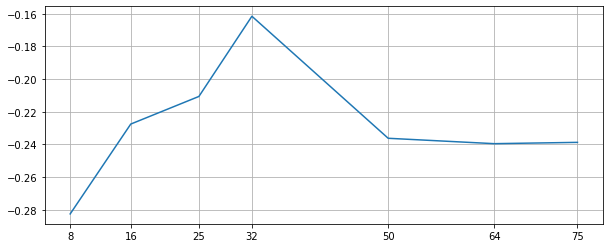

In [13]:
import seaborn as sns

l = [8, 16, 25, 32, 50, 64, 75]

c = [-0.2825, -0.2275, -0.2106, -0.1615, -0.2362, -0.2395, -0.2387]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.grid(True)
# plt.set_xticks(l)

g = sns.lineplot(l, c)
g.set_xticks(l)

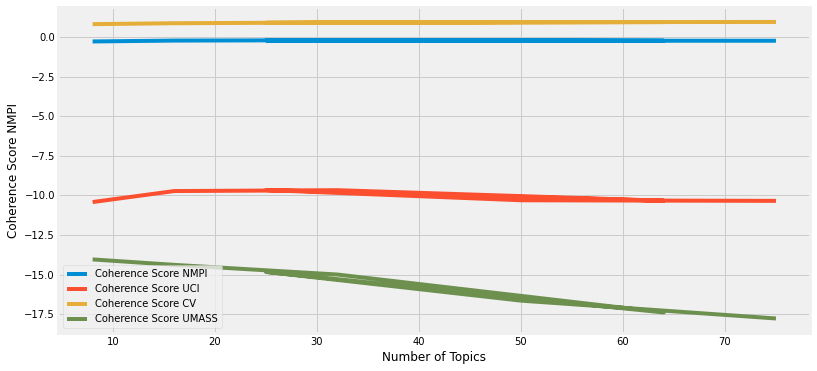

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

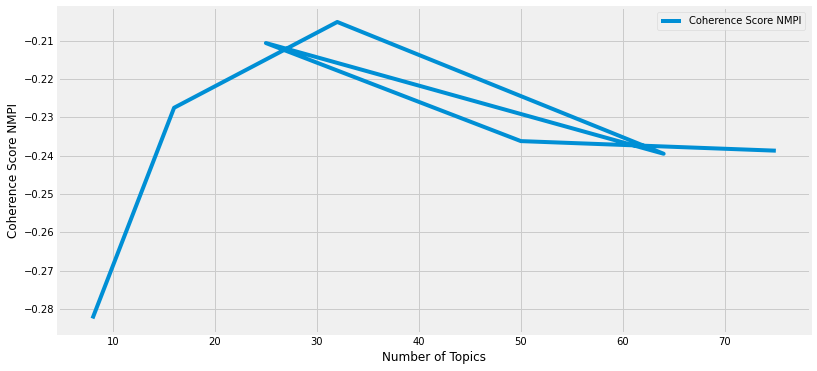

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

In [ ]:
topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
24,31,-0.1615,-8.9697,0.9155,-14.6769
17,22,-0.1635,-8.9058,0.8966,-13.7770
26,34,-0.1737,-9.1599,0.9204,-15.1488
27,35,-0.1784,-9.2440,0.9294,-14.9201
31,40,-0.1797,-9.3564,0.9305,-15.2818
28,36,-0.1840,-9.3417,0.9279,-15.3803
35,45,-0.1885,-9.4353,0.9371,-15.8887
33,42,-0.1917,-9.5432,0.9343,-15.4404
36,46,-0.1928,-9.5764,0.9360,-15.5241
37,47,-0.1951,-9.5879,0.9414,-16.1289


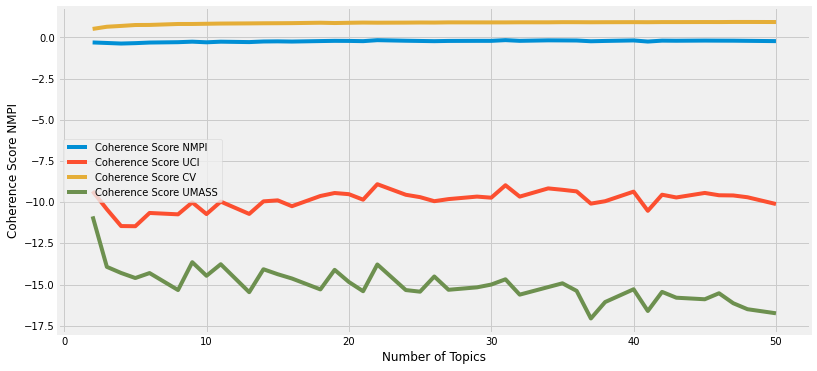

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

## Pseudo-document LDA

In [ ]:
pdm = tp.PTModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K, p = 10*K)


v, dt = model_pipeline(pdm, norm_issues)
v.display(dt)

Num docs: 412 , Vocab size: 1416 , Num words: 20290
Removed top words: ['looking', 'file', 'http', 'found', 'gulp']
Iteration: 0	Log-likelihood: -7.163525376935614
Iteration: 10	Log-likelihood: -6.290975949657322
Iteration: 20	Log-likelihood: -6.254786471235981
Iteration: 30	Log-likelihood: -6.226937102069991
Iteration: 40	Log-likelihood: -6.2194346590647855
Iteration: 50	Log-likelihood: -6.217781736365735
Iteration: 60	Log-likelihood: -6.218501426574043
Iteration: 70	Log-likelihood: -6.21329296255946
Iteration: 80	Log-likelihood: -6.211321290779607
Iteration: 90	Log-likelihood: -6.21376434974097
Iteration: 100	Log-likelihood: -6.214262933214642
Iteration: 110	Log-likelihood: -6.21170110194891
Iteration: 120	Log-likelihood: -6.212045637843878
Iteration: 130	Log-likelihood: -6.213439884930188
Iteration: 140	Log-likelihood: -6.208924220893817
Iteration: 150	Log-likelihood: -6.209519361071894
Iteration: 160	Log-likelihood: -6.209438004026335
Iteration: 170	Log-likelihood: -6.2047146543662

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Word Cloud

### Backend Scripts

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def topics_to_wordclouds(model, topic_dict, save=False):
    '''Wrapper function that generates wordclouds for ALL topics of a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_dic: dict -> per topic, an arrays with top words and associated frequencies
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots
    '''
    
    wcloud = WordCloud(background_color="white")
    fig, ax = plt.subplots(1, 3, figsize=(15,4))

    cnt=0
    for k, arr in topic_dict.items():
        
        create_wordcloud(model, k, fig, ax[cnt], save)
        ax[cnt].title.set_text("Topic # " + str(k))
        cnt+=1
        
        if cnt==3:
            cnt=0
            fig, ax = plt.subplots(1, 3, figsize=(15,4))
    
    
              

def create_wordcloud(model, topic_idx, fig, ax, save=False):
    '''Wrapper function that generates individual wordclouds from topics in a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_idx: int -> topic index
    fig, ax: obj -> pyplot objects from subplots method
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots'''
    wcloud = WordCloud(background_color='white')
    
    topic_freqs = dict(model.get_topic_words(topic_idx))
    
    img = wcloud.generate_from_frequencies(topic_freqs)
    
    ax.imshow(img, interpolation='bilinear')
    ax.axis('off')
    
    if save:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        img_name = "wcloud_topic_" + str(topic_idx) +'.png'
        plt.savefig(''.join(['imgs/',img_name]), bbox_inches=extent.expanded(1.1, 1.2))

In [ ]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_topics_top_words(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        #if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

### Vanilla LDA - Word Cloud

1. Topics of issues of the same pattern
2. Topics of issues of the different patterns

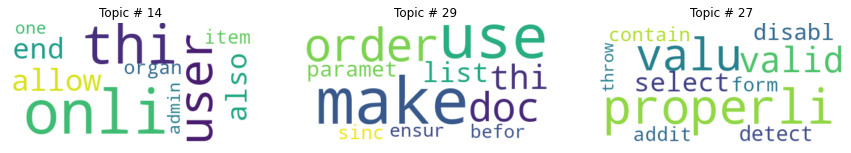

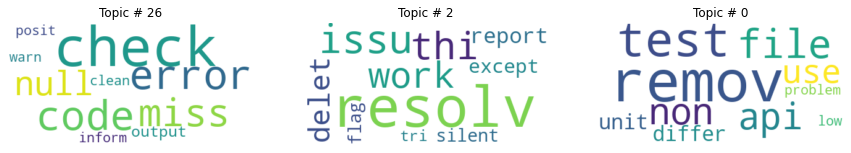

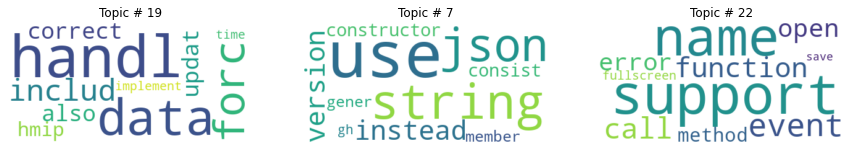

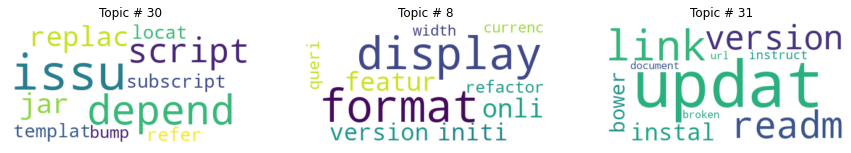

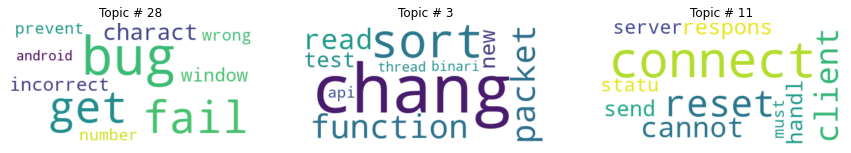

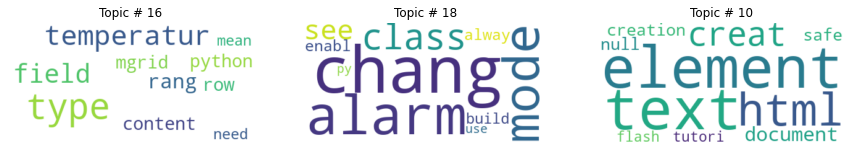

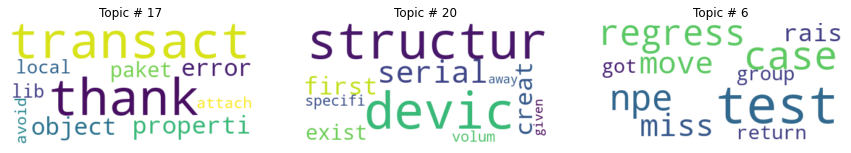

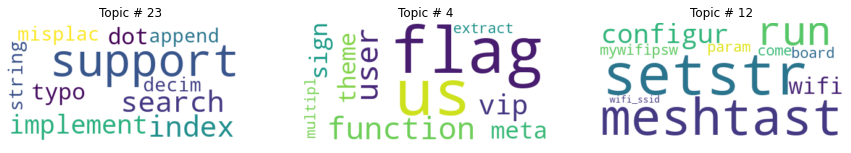

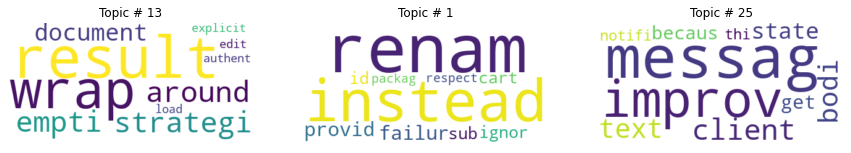

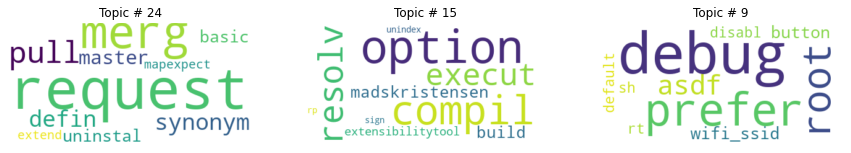

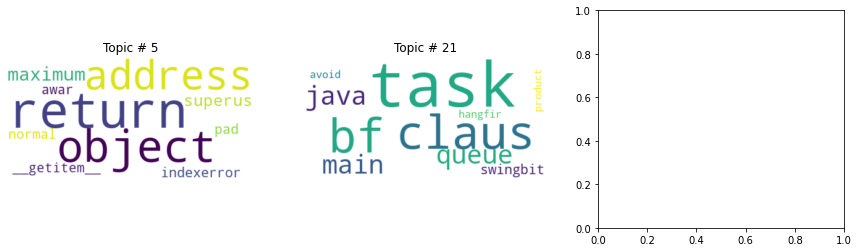

In [ ]:
best_lda = lda
topics_top_words = get_topics_top_words(best_lda, top_n=10)
topics_to_wordclouds(best_lda, topics_top_words)

In [ ]:
best_lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 501 docs, 2771 words
| Total Vocabs: 1223, Used Vocabs: 1218
| Entropy of words: 6.65964
| Entropy of term-weighted words: 6.65964
| Removed Vocabs: fix close ad add set
|
<Training Info>
| Iterations: 1000, Burn-in steps: 10
| Optimization Interval: 10
| Log-likelihood per word: -7.94577
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.0

In [ ]:
lda = best_lda

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=0, min_df=0, max_len=5, max_cand=10000)
cands = extractor.extract(best_lda)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(best_lda, cands, min_df=0, smoothing=1e-2, mu=0.25)
for k in range(best_lda.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in best_lda.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: low, ascii, non ascii, low level code deal non, fix idea
remov	0.11657513678073883
test	0.07497087866067886
file	0.050008323043584824
non	0.04168746992945671
api	0.04168746992945671
use	0.0333666168153286
differ	0.025045763701200485
unit	0.025045763701200485
problem	0.025045763701200485
low	0.025045763701200485

== Topic #1 ==
Labels: previou name scheme, zmqxreq zmqxrep zmqreq, zmqxrep zmqreq zmqrep, respect updat doctyp accordingli, name scheme
renam	0.05001247301697731
instead	0.05001247301697731
provid	0.037540532648563385
failur	0.037540532648563385
ignor	0.02506859600543976
id	0.02506859600543976
sub	0.02506859600543976
cart	0.02506859600543976
respect	0.02506859600543976
packag	0.02506859600543976

== Topic #2 ==
Labels: thi resolv, silent, resolv, crash report silent via smtp, send crash report silent
resolv	0.19491800665855408
issu	0.08126319199800491
thi	0.07314499467611313
work	0.06502678990364075
delet	0.040672190487384796
report	0.040672190487384796


Anomaly 1: ElasticSearch configuration


Anomaly 2: Maven configuration

# Save Topic Model

## Saving The Topics

In [ ]:
best_lda = lda
best_lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 501 docs, 2771 words
| Total Vocabs: 1223, Used Vocabs: 1218
| Entropy of words: 6.65964
| Entropy of term-weighted words: 6.65964
| Removed Vocabs: fix close ad add set
|
<Training Info>
| Iterations: 1000, Burn-in steps: 10
| Optimization Interval: 10
| Log-likelihood per word: -7.94577
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.0

In [ ]:
model_path = os.path.join(PATH, "models", "commits_lda.bin")
mapping_path = os.path.join(PATH, "models", "issue_commit.csv")


#docs = best_lda.docs
#topics_dist, ll = best_lda.infer(docs) 

#best_lda.save(model_path)

In [ ]:
# len(set(issues_idx)), len(issues_idx)
# issues_idx
tt = tp.LDAModel.load(model_path)
tt.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 501 docs, 2771 words
| Total Vocabs: 1223, Used Vocabs: 1218
| Entropy of words: 6.65964
| Entropy of term-weighted words: 6.65964
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 10
| Optimization Interval: 10
| Log-likelihood per word: -7.94577
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.06084735 0.031599

In [ ]:
i=0
best_lda = tt
mapping_df = pd.DataFrame()
for d in iter(best_lda.docs):
  topic = np.argmax(best_lda.infer(d)[0])
  # if issues_idx[i] is iter and len(issues_idx[i]) > 0:
    # print(issues_idx[i])
  issue = norm_commits_idx[i]
  i += 1
  mapping_df = mapping_df.append({'issue':issue, 'topic':topic}, ignore_index =True)

In [ ]:
best_lda.k

32

In [ ]:
# mapping_df[mapping_df['issue'].duplicated()].sort_values("issue")
mapping_df['issue'].drop_duplicates()
# mapping_df['issue']

0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
       ...  
496    496.0
497    497.0
498    498.0
499    499.0
500    500.0
Name: issue, Length: 501, dtype: float64

In [ ]:
mapping_df = mapping_df.astype(int)

mapping_df.shape[0], len(mapping_df['issue'].unique())

(501, 501)

Save the mapping to the disk

In [ ]:
mapping_df.to_csv(mapping_path, index = None)

In [ ]:
Counter(issues.loc[mapping_df[mapping_df['topic'] ==1]['issue']]['repository_url'])

Counter({'"https://api.github.com/repos/MadStudioRoblox/ProfileService"': 2,
         '"https://api.github.com/repos/cryptokylin/CryptoKylin-Testnet"': 1,
         '"https://api.github.com/repos/pitiwazou/Scripts-Blender"': 1,
         '"https://api.github.com/repos/react-toolbox/react-toolbox-example"': 2,
         '"https://api.github.com/repos/sirkitree/angular-directive.g-signin"': 2,
         '"https://api.github.com/repos/web3p/ethereum-tx"': 3})

Load Topic model from disk

In [ ]:
tt = tp.LDAModel.load(model_path)
tt.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 501 docs, 2771 words
| Total Vocabs: 1223, Used Vocabs: 1218
| Entropy of words: 6.65964
| Entropy of term-weighted words: 6.65964
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 10
| Optimization Interval: 10
| Log-likelihood per word: -7.94577
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.06084735 0.031599

In [ ]:
tt.perplexity

2823.617339842067